In [38]:
# DASK client set
import os
import sys
from dask.distributed import Client
client = Client(scheduler_file='/proj/kimyy/Dropbox/source/python/all/mpi/scheduler.json')  

def setup_module_path():
    module_path = '/proj/kimyy/Dropbox/source/python/all/Modules/CESM2'
    if module_path not in sys.path:
        sys.path.append(module_path)

client.run(setup_module_path)
client

# get path for path changes in Jupyter notebook: File - Open from Path - insert relative_path
notebook_path = os.path.abspath(".")
_, _, relative_path = notebook_path.partition('/all/')
relative_path = '/all/' + relative_path
relative_path

'/all/Model/CESM2/Earth_System_Predictability/ASSM/Aleph'

2024-09-25 14:48:55,588 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
2024-09-25 14:48:55,589 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client


# Load modules

In [2]:
# load public modules

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import stats
import cmocean
from cmcrameri import cm
import warnings
warnings.simplefilter(action='ignore')
import pandas as pd
import cftime
import pop_tools
from pprint import pprint
import time
import subprocess
import re as re_mod
import cftime
import datetime
from scipy.stats import ttest_1samp

In [3]:
# load private modules

import sys
sys.path.append('/proj/kimyy/Dropbox/source/python/all/Modules/CESM2')
from KYY_CESM2_preprocessing import CESM2_config
# import KYY_CESM2_preprocessing
# import importlib
# importlib.reload(KYY_CESM2_preprocessing)

# Variable configuration

In [4]:
cfg_var=CESM2_config()
cfg_var.year_s=1960
cfg_var.year_e=2020
cfg_var.setvar('SSH')
cfg_var.list()

if cfg_var.comp=='ocn':
    ds_grid = pop_tools.get_grid('POP_gx1v7')

{'codebase': 'e21',
 'comp': 'ocn',
 'compset': 'b',
 'dimension': 'time '
              'nlat '
              'nlon',
 'long_name': 'SSH**2',
 'model': 'pop.h',
 'ndim': 3,
 'resol': 'f09_g17',
 'tfreq': 'month_1',
 'unit': 'cm^2',
 'var': 'SSH',
 'year_e': 2020,
 'year_s': 1960}


# Read files

In [5]:
# define preprocessing function

exceptcv=['time','lon','lat','lev', 'TLONG', 'TLAT', 'z_w', cfg_var.var]
def process_coords(ds, sd, ed, drop=True, except_coord_vars=exceptcv):
    """Preprocessor function to drop all non-dim coords, which slows down concatenation."""
    coord_vars = []
    for v in np.array(ds.coords) :
        if not v in except_coord_vars:
            coord_vars += [v]
    for v in np.array(ds.data_vars) :
        if not v in except_coord_vars:
            coord_vars += [v]
    
    if drop:
        ds= ds.drop(coord_vars)
        ds= ds.sel(time=slice(sd, ed))
        return ds
    else:
        return ds.set_coords(coord_vars)


start_date = cftime.DatetimeNoLeap(cfg_var.year_s, 2, 1)
end_date = cftime.DatetimeNoLeap(cfg_var.year_e+1, 1, 1)

In [6]:
# Read LE dataset

start_time = time.time()


cfg_var.LE_path_load(cfg_var.var)
cfg_var.LE_ds = xr.open_mfdataset(cfg_var.LE_file_list[0], 
                       chunks={'time': 12}, 
                       combine='nested', 
                       concat_dim=[[*cfg_var.LE_ensembles], 'time'], 
                       parallel=True,
                       preprocess=lambda ds: process_coords(ds, start_date, end_date),
                       decode_cf=True, 
                       decode_times=True)      


cfg_var.LE_ds = cfg_var.LE_ds.rename({"concat_dim": "ens_LE"})
new_time = cfg_var.LE_ds.time - np.array([datetime.timedelta(days=15)] * len(cfg_var.LE_ds.time))
cfg_var.LE_ds = cfg_var.LE_ds.assign_coords(time=new_time)

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for reading LE: ' + str(elapsed_time))

elasped time for reading LE: 83.69569611549377


In [7]:
# # Read ODA dataset (all)

# start_time = time.time()

# cfg_var.ODA_path_load(cfg_var.var)

# ODA_ds2 = xr.open_mfdataset(cfg_var.ODA_file_list[0][10:20], 
#                            chunks={'time': 2}, 
#                            combine='nested', 
#                            concat_dim=[[*cfg_var.ODA_ensembles[10:20]], 'time'], 
#                            parallel=True,
#                            preprocess=lambda ds: process_coords(ds, start_date, end_date),
#                            decode_cf=True, 
#                            decode_times=True)

# ODA_ds2_a = []
# ODA_ds2_a.append(ODA_ds2)
# ODA_ds2_xr = xr.concat(ODA_ds2_a, dim='time')
# ODA_ds2_xr = ODA_ds2_xr.expand_dims({'ens': range(10, 20)})

# cfg_var.ODA_ds = []
# # cfg_var.ODA_ds.append(ODA_ds_xr)
# cfg_var.ODA_ds.append(ODA_ds2_xr)
# cfg_var.ODA_ds = xr.concat(cfg_var.ODA_ds, dim='ens')
# cfg_var.ODA_ds = cfg_var.ODA_ds.reindex(ens=list(range(1, 20+1)))
# cfg_var.ODA_ds = cfg_var.ODA_ds.sortby('time')

# cfg_var.ODA_ds = cfg_var.ODA_ds.rename({"concat_dim": "ens_ODA"})
# new_time = cfg_var.ODA_ds.time - np.array([datetime.timedelta(days=15)] * len(cfg_var.ODA_ds.time))
# cfg_var.ODA_ds = cfg_var.ODA_ds.assign_coords(time=new_time)
# cfg_var.ODA_ds = cfg_var.ODA_ds.drop('ens')
# cfg_var.ODA_ds=cfg_var.ODA_ds.mean(dim='ens')
# end_time = time.time()
# elapsed_time = end_time - start_time
# print('elasped time for reading ODA: ' + str(elapsed_time))

In [8]:
# Read ODA dataset (projd only)
start_time = time.time()

cfg_var.ODA_path_load(cfg_var.var)

cfg_var.ODA_ds = xr.open_mfdataset(cfg_var.ODA_file_list[0][10:20], 
                           chunks={'time': 2}, 
                           combine='nested', 
                           concat_dim=[[*cfg_var.ODA_ensembles[10:20]], 'time'], 
                           parallel=True,
                           preprocess=lambda ds: process_coords(ds, start_date, end_date),
                           decode_cf=True, 
                           decode_times=True)

cfg_var.ODA_ds = cfg_var.ODA_ds.rename({"concat_dim": "ens_ODA"})
new_time = cfg_var.ODA_ds.time - np.array([datetime.timedelta(days=15)] * len(cfg_var.ODA_ds.time))
cfg_var.ODA_ds = cfg_var.ODA_ds.assign_coords(time=new_time)

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for reading ODA: ' + str(elapsed_time))

elasped time for reading ODA: 445.00903844833374


In [9]:
#Read ADA dataset
start_time = time.time()

cfg_var.ADA_path_load(cfg_var.var)
cfg_var.ADA_ds = xr.open_mfdataset(cfg_var.ADA_file_list[0], 
                       chunks={'time': 12}, 
                       combine='nested',
                       concat_dim=[[*cfg_var.ADA_ensembles], 'time'], 
                       parallel=True,
                       preprocess=lambda ds: process_coords(ds, start_date, end_date),
                       decode_cf=True, 
                       decode_times=True)      


cfg_var.ADA_ds = cfg_var.ADA_ds.rename({"concat_dim": "ens_ADA"})
new_time = cfg_var.ADA_ds.time - np.array([datetime.timedelta(days=15)] * len(cfg_var.ADA_ds.time))
cfg_var.ADA_ds = cfg_var.ADA_ds.assign_coords(time=new_time)

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for reading ADA: ' + str(elapsed_time))

elasped time for reading ADA: 30.22637104988098


In [10]:
# Read Observation dataset
start_time = time.time()

cfg_var.OBS_path_load(cfg_var.var)
# cfg_var.OBS_ds = xr.open_mfdataset(cfg_var.OBS_file_list[0][0], 
#                        combine='nested',
#                        concat_dim= 'time',
#                        chunks={'time': 6}, 
#                        parallel=True,
#                        preprocess=lambda ds: process_coords(ds, start_date, end_date),
#                        decode_cf=True, 
#                        decode_times=True,
#                        engine='h5netcdf')
cfg_var.OBS_ds = xr.open_mfdataset(cfg_var.OBS_file_list[0][0], 
                       chunks={'time': 6}, 
                       parallel=True,
                       decode_cf=True, 
                       decode_times=True,)
cfg_var.OBS_ds = cfg_var.OBS_ds.rename({cfg_var.OBS_var: cfg_var.var})

cfg_var.OBS_ds=cfg_var.OBS_ds.assign_coords(time=cfg_var.ADA_ds.time[396:732])
cfg_var.OBS_ds.time

# global mean removal for SSH
if cfg_var.var=='SSH':
    lat_mask = (ds_grid.TLAT >= -60) & (ds_grid.TLAT <= 60)

    area_selected = ds_grid.TAREA.where(lat_mask, drop=True)  # 선택된 지역의 면적
    ssh_selected = cfg_var.OBS_ds[cfg_var.var].where(lat_mask, drop=True)  # 선택된 지역의 SSH 데이터

    # 필터링된 지역에 대해 global mean 계산
    cfg_var.OBS_ds['gm'] = (ssh_selected * area_selected).sum(dim=['nlat', 'nlon']) / area_selected.sum(dim=['nlat', 'nlon'])
    
    # 원 데이터에서 global mean을 제거한 값
    cfg_var.OBS_ds['SSH'] = cfg_var.OBS_ds[cfg_var.var] - cfg_var.OBS_ds['gm']

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for reading OBS: ' + str(elapsed_time))

elasped time for reading OBS: 29.592775106430054


# Take annual means

In [11]:
# obs_non_nan_times = cfg_var.OBS_ds.notnull()
# ada_filtered = cfg_var.ADA_ds.sel(time=obs_non_nan_times)

# Step 1: OBS_ds에서 NaN이 아닌 시간대에 해당하는 boolean mask 생성
obs_non_nan_times = cfg_var.OBS_ds[cfg_var.var].notnull().any(dim=['nlat', 'nlon'])
# Step 2: boolean mask를 명시적으로 계산 (compute() 호출)
obs_non_nan_times = obs_non_nan_times.compute()
# Step 3: NaN이 아닌 시간대에 해당하는 time 좌표 추출
non_nan_time_coords = cfg_var.OBS_ds.time.where(obs_non_nan_times, drop=True)
# Step 4: ADA_ds에서 NaN이 아닌 시간대에 해당하는 자료만 선택
ada_filtered = cfg_var.ADA_ds.sel(time=non_nan_time_coords)
oda_filtered = cfg_var.ODA_ds.sel(time=non_nan_time_coords)
le_filtered = cfg_var.LE_ds.sel(time=non_nan_time_coords)

# Step 5: 연도별로 그룹화하고 NaN을 무시한 연평균 계산
ada_annual_mean = ada_filtered.groupby('time.year').mean(dim='time', skipna=True)
oda_annual_mean = oda_filtered.groupby('time.year').mean(dim='time', skipna=True)
le_annual_mean = le_filtered.groupby('time.year').mean(dim='time', skipna=True)
obs_annual_mean = cfg_var.OBS_ds.groupby('time.year').mean(dim='time', skipna=True)

In [12]:
# take ensemble mean, increments (ODA-LE, ADA-ODA)

ada_annual_mean['enm']=ada_annual_mean[cfg_var.var].mean(dim='ens_ADA')
oda_annual_mean['enm']=oda_annual_mean[cfg_var.var].mean(dim='ens_ODA')
le_annual_mean['enm']=le_annual_mean[cfg_var.var].mean(dim='ens_LE')

oda_annual_mean['diff_le']=oda_annual_mean[cfg_var.var] - le_annual_mean.enm
ada_annual_mean['diff_oda']=ada_annual_mean[cfg_var.var] - oda_annual_mean.enm

In [13]:
start_time = time.time()

# corr = xr.corr(cfg_var.ADA_ds[cfg_var.var], cfg_var.LE_ds[cfg_var.var], dim='time')
# corr = xr.corr(cfg_var.ADA_ds[cfg_var.var], cfg_var.ODA_ds[cfg_var.var], dim='time')
# corr = xr.corr(cfg_var.ADA_ds[cfg_var.var], getattr(cfg_var.OBS_ds, cfg_var.var), dim='time')
corr_ADA = xr.corr(ada_annual_mean[cfg_var.var], getattr(obs_annual_mean,cfg_var.var), dim='year')
corr_ADA_diff = xr.corr(ada_annual_mean.diff_oda, getattr(obs_annual_mean,cfg_var.var), dim='year')
corr_ODA = xr.corr(oda_annual_mean[cfg_var.var], getattr(obs_annual_mean,cfg_var.var), dim='year')
corr_ODA_diff = xr.corr(oda_annual_mean.diff_le, getattr(obs_annual_mean,cfg_var.var), dim='year')
corr_LE = xr.corr(le_annual_mean[cfg_var.var], getattr(obs_annual_mean,cfg_var.var), dim='year')

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for reading ADA: ' + str(elapsed_time))

elasped time for reading ADA: 204.0324935913086


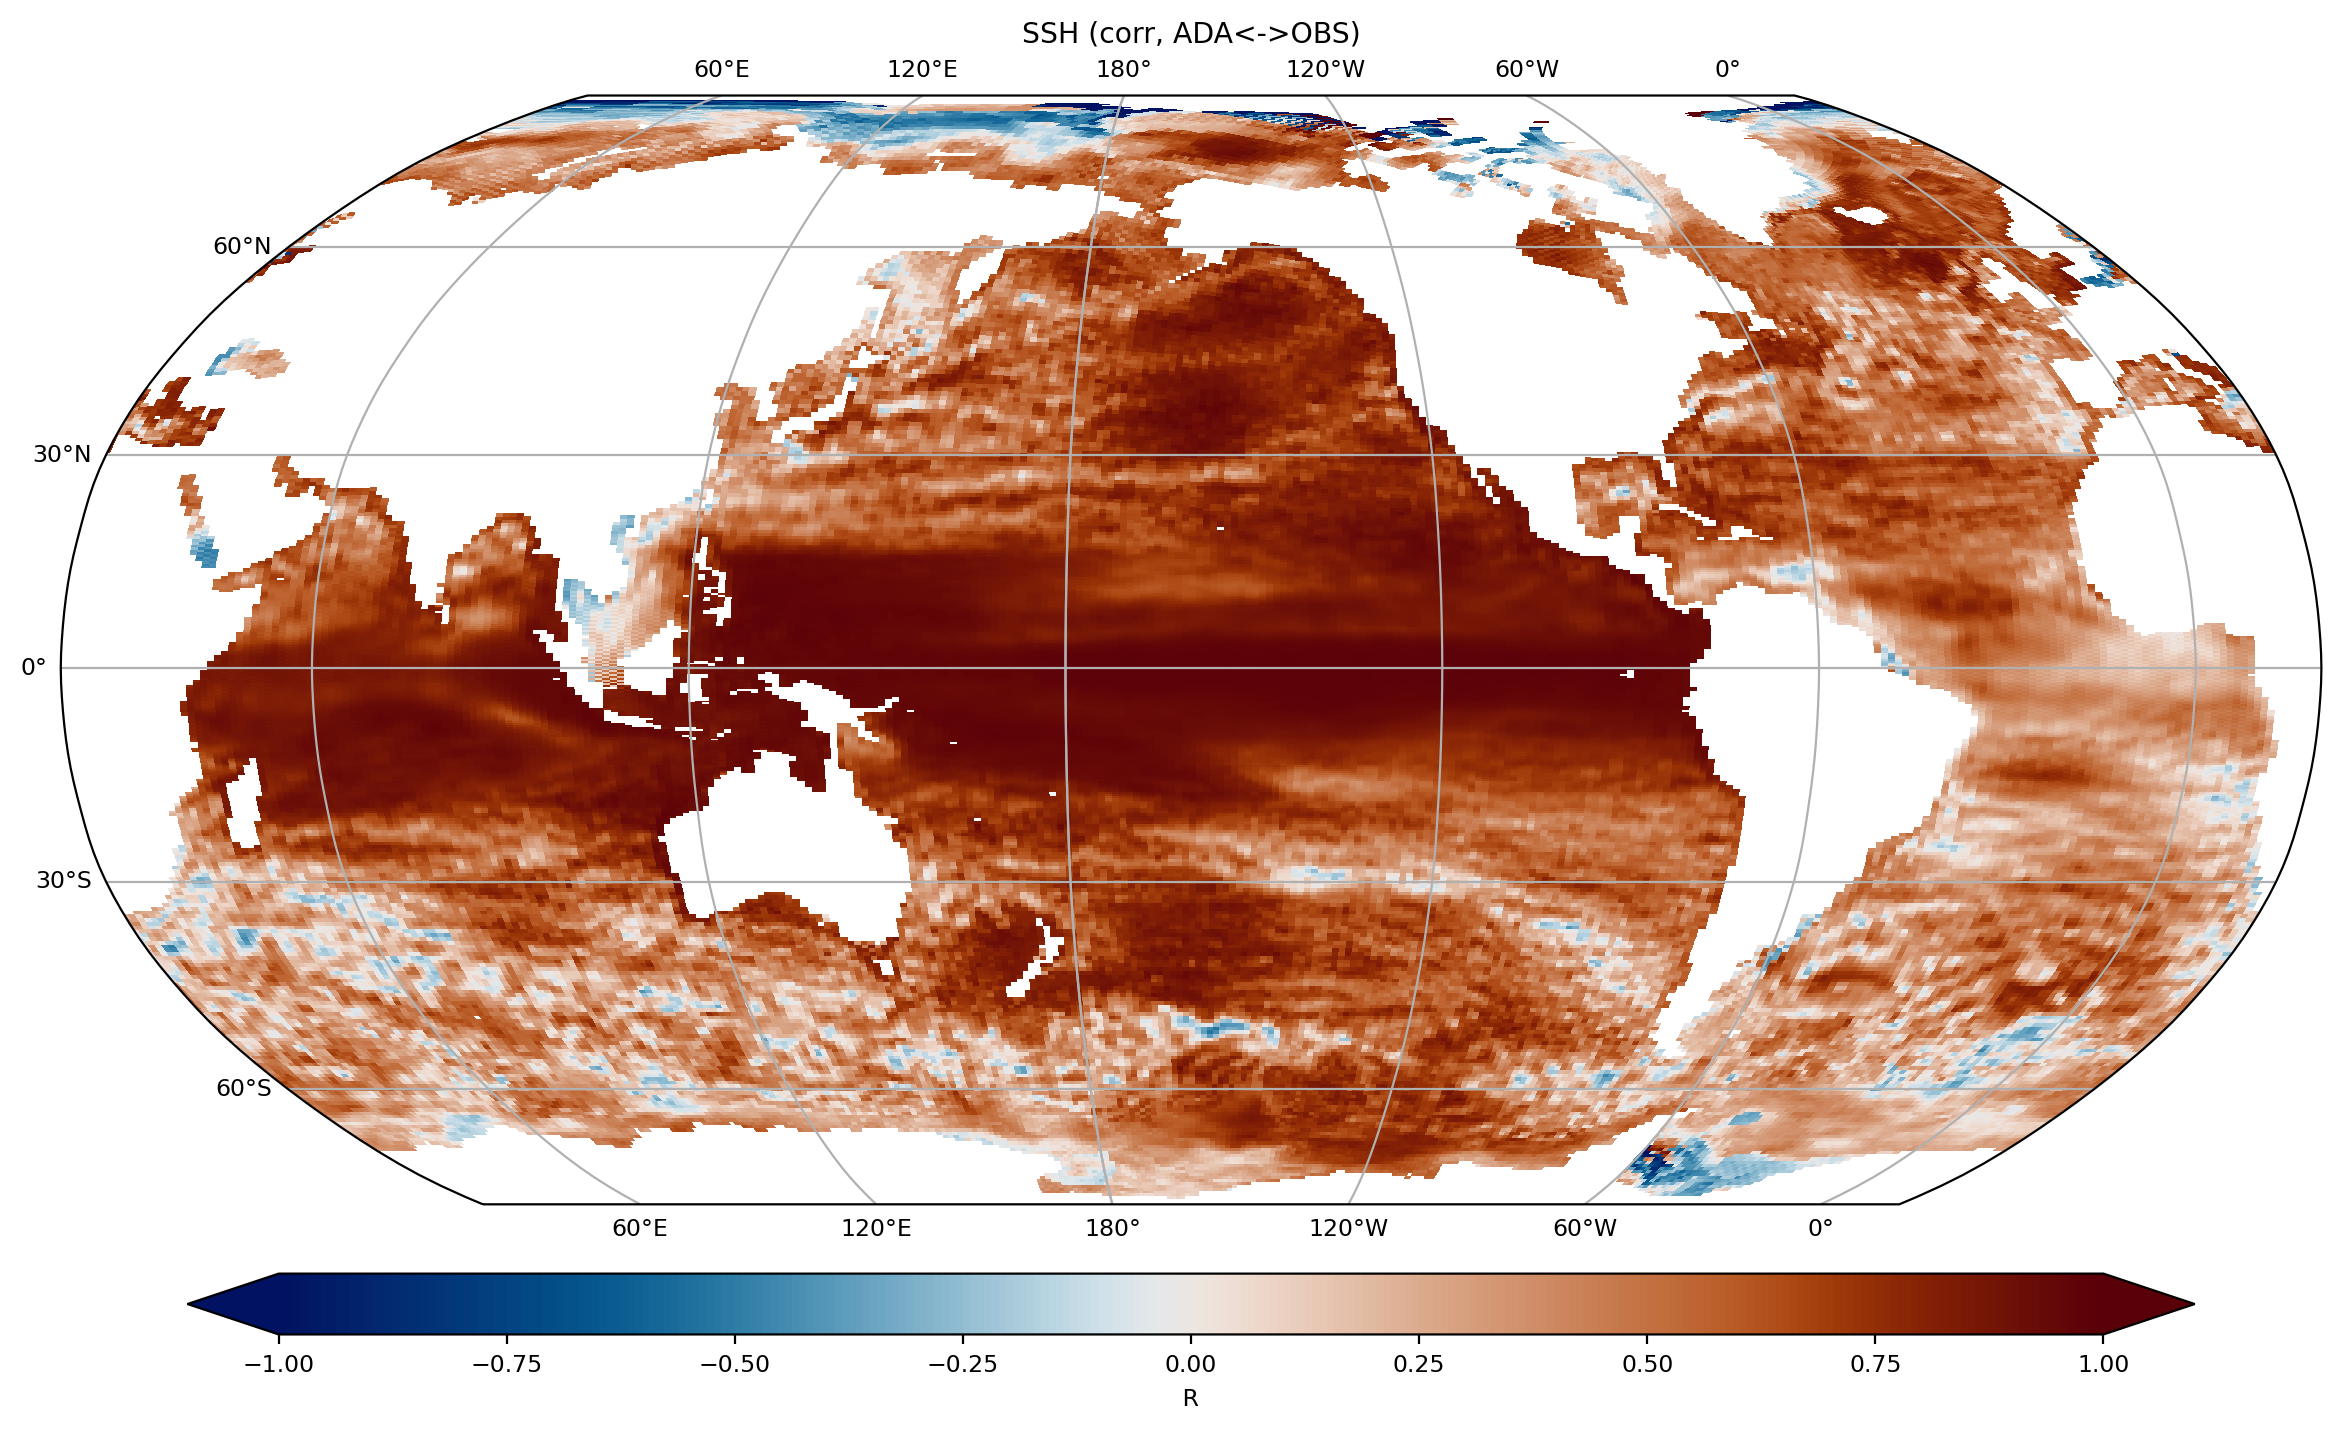

In [14]:
# plot for ADA

def pop_add_cyclic(da):
        #copied from Mattew Longs github (https://gist.github.com/matt-long/50433da346da8ac17cde926eec90a87c) and modified for DA
        #This doesn't work with Dask (DA should be loaded)
        #Input DA must have the name and coords (TLONG and TLAT), and don't have other dims (time etc.)
        #Output is DA
        nj = da.TLAT.shape[0]
        ni = da.TLONG.shape[1]
        xL = int(ni/2 - 1)
        xR = int(xL + ni)
        tlon = da.TLONG.data
        tlat = da.TLAT.data
        tlon = np.where(np.greater_equal(tlon, min(tlon[:,0])), tlon-360., tlon)
        lon  = np.concatenate((tlon, tlon + 360.), 1)
        lon = lon[:, xL:xR]
        if ni == 320:
            lon[367:-3, 0] = lon[367:-3, 0] + 360.
        lon = lon - 360.
        lon = np.hstack((lon, lon[:, 0:1] + 360.))
        if ni == 320:
            lon[367:, -1] = lon[367:, -1] - 360.
        #-- trick cartopy into doing the right thing:
        #   it gets confused when the cyclic coords are identical
        lon[:, 0] = lon[:, 0] - 1e-8
        #-- periodicity
        lat = np.concatenate((tlat, tlat), 1)
        lat = lat[:, xL:xR]
        lat = np.hstack((lat, lat[:,0:1]))
        TLAT = xr.DataArray(lat, dims=('nlat', 'nlon'))
        TLONG = xr.DataArray(lon, dims=('nlat', 'nlon'))
        # copy vars
        v = da.name
        v_dims = da.dims
        # determine and sort other dimensions
        other_dims = set(v_dims) - {'nlat', 'nlon'}
        other_dims = tuple([d for d in v_dims if d in other_dims])
        lon_dim = da.dims.index('nlon')
        field = da.data
        field = np.concatenate((field, field), lon_dim)
        field = field[:, xL:xR]
        field = np.concatenate((field, field[:, 0:1]), lon_dim)
        dao = xr.DataArray(field, dims=other_dims+('nlat', 'nlon'), attrs=da.attrs)
        dao = dao.assign_coords(TLONG=TLONG)
        dao = dao.assign_coords(TLAT=TLAT)
        return dao


varn=cfg_var.var #example

if cfg_var.comp=='ocn':
    ds_grid = pop_tools.get_grid('POP_gx1v7')

# data_array=corr.mean(dim='ens_ADA').mean(dim='concat_dim')
data_array=corr_ADA.mean(dim='ens_ADA')

data_array.attrs['name'] = cfg_var.var

if cfg_var.var == 'SST':
    data_array = data_array.where(data_array != 0, np.nan)
if cfg_var.comp=='ocn':
    data_array['TLONG']=ds_grid.TLONG
    data_array['TLAT']=ds_grid.TLAT

# data_array = np.nan_to_num(data_array)

# data_array.isel(concat_dim=0).isel(time=0).plot()

projection = ccrs.Robinson(central_longitude=200)

plt.rcParams.update({'font.size': 8.5})
fig, ax2 = plt.subplots(1, 1, figsize=(18.5, 9), dpi=200, facecolor='w', edgecolor='k', subplot_kw={'projection': projection})

cbar_kwargs={'orientation':'horizontal','pad':0.05,'shrink':0.7, 'label':' R ', 'aspect':33, 'extend': 'both'}
if cfg_var.comp=='ocn' or cfg_var.comp=='ice':
    # plt1=pop_add_cyclic(data_array).plot.pcolormesh(x='TLONG', y='TLAT', ax=ax2, transform=ccrs.PlateCarree(), vmax=0.05, vmin=-0.05,cmap=cm.vik, cbar_kwargs=cbar_kwargs)
    plt1=pop_add_cyclic(data_array).plot.pcolormesh(x='TLONG', y='TLAT', ax=ax2, transform=ccrs.PlateCarree(), vmax=1, vmin=-1,cmap=cm.vik, cbar_kwargs=cbar_kwargs)

else:
    plt1=data_array.isel(concat_dim=0).mean(dim='time').plot.pcolormesh(ax=ax2, transform=ccrs.PlateCarree(), vmax=30, vmin=0, cmap=cmocean.cm.deep, cbar_kwargs=cbar_kwargs)

ax2.set_title(f'{varn} (corr, ADA<->OBS)')
ax2.gridlines(draw_labels=True) 

ax2.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}°'))
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0f}°'))

plt.show()

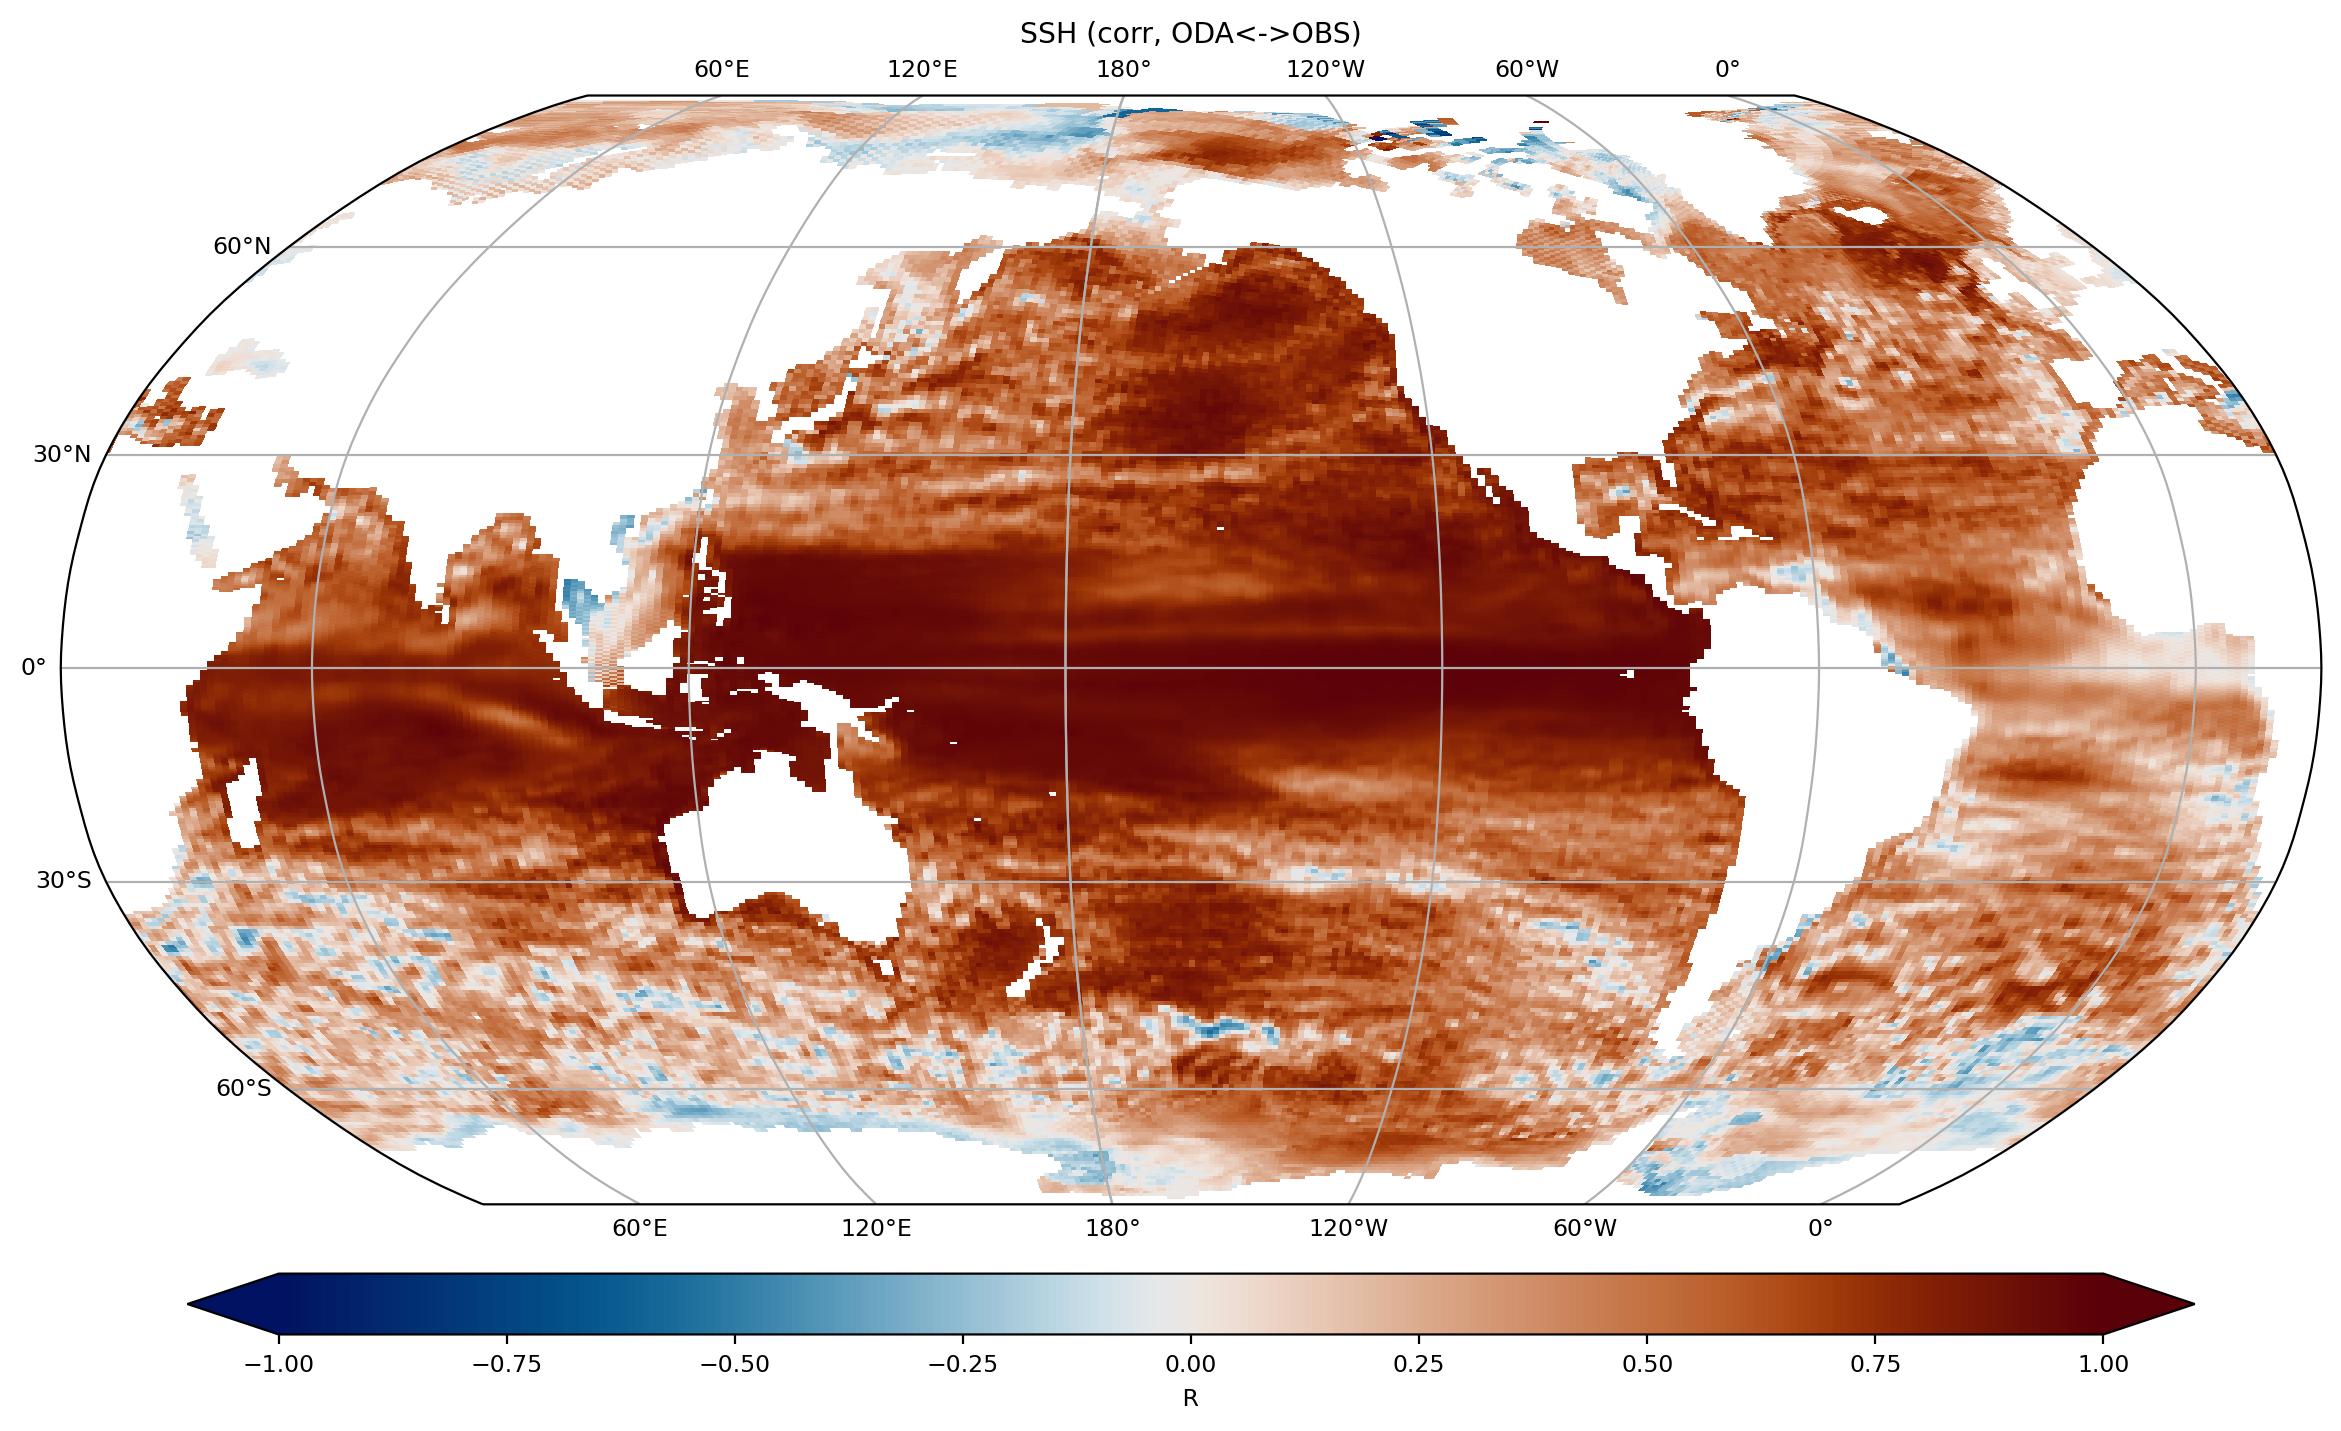

In [15]:
# plot for ODA


varn=cfg_var.var #example

if cfg_var.comp=='ocn':
    ds_grid = pop_tools.get_grid('POP_gx1v7')

# data_array=corr.mean(dim='ens_ADA').mean(dim='concat_dim')
data_array=corr_ODA.mean(dim='ens_ODA')

data_array.attrs['name'] = cfg_var.var

if cfg_var.var == 'SST':
    data_array = data_array.where(data_array != 0, np.nan)
if cfg_var.comp=='ocn':
    data_array['TLONG']=ds_grid.TLONG
    data_array['TLAT']=ds_grid.TLAT

# data_array = np.nan_to_num(data_array)

# data_array.isel(concat_dim=0).isel(time=0).plot()

projection = ccrs.Robinson(central_longitude=200)

plt.rcParams.update({'font.size': 8.5})
fig, ax2 = plt.subplots(1, 1, figsize=(18.5, 9), dpi=200, facecolor='w', edgecolor='k', subplot_kw={'projection': projection})

cbar_kwargs={'orientation':'horizontal','pad':0.05,'shrink':0.7, 'label':' R ', 'aspect':33, 'extend': 'both'}
if cfg_var.comp=='ocn' or cfg_var.comp=='ice':
    # plt1=pop_add_cyclic(data_array).plot.pcolormesh(x='TLONG', y='TLAT', ax=ax2, transform=ccrs.PlateCarree(), vmax=0.05, vmin=-0.05,cmap=cm.vik, cbar_kwargs=cbar_kwargs)
    plt1=pop_add_cyclic(data_array).plot.pcolormesh(x='TLONG', y='TLAT', ax=ax2, transform=ccrs.PlateCarree(), vmax=1, vmin=-1,cmap=cm.vik, cbar_kwargs=cbar_kwargs)

else:
    plt1=data_array.isel(concat_dim=0).mean(dim='time').plot.pcolormesh(ax=ax2, transform=ccrs.PlateCarree(), vmax=30, vmin=0, cmap=cmocean.cm.deep, cbar_kwargs=cbar_kwargs)

ax2.set_title(f'{varn} (corr, ODA<->OBS)')
ax2.gridlines(draw_labels=True) 

ax2.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}°'))
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0f}°'))

plt.show()

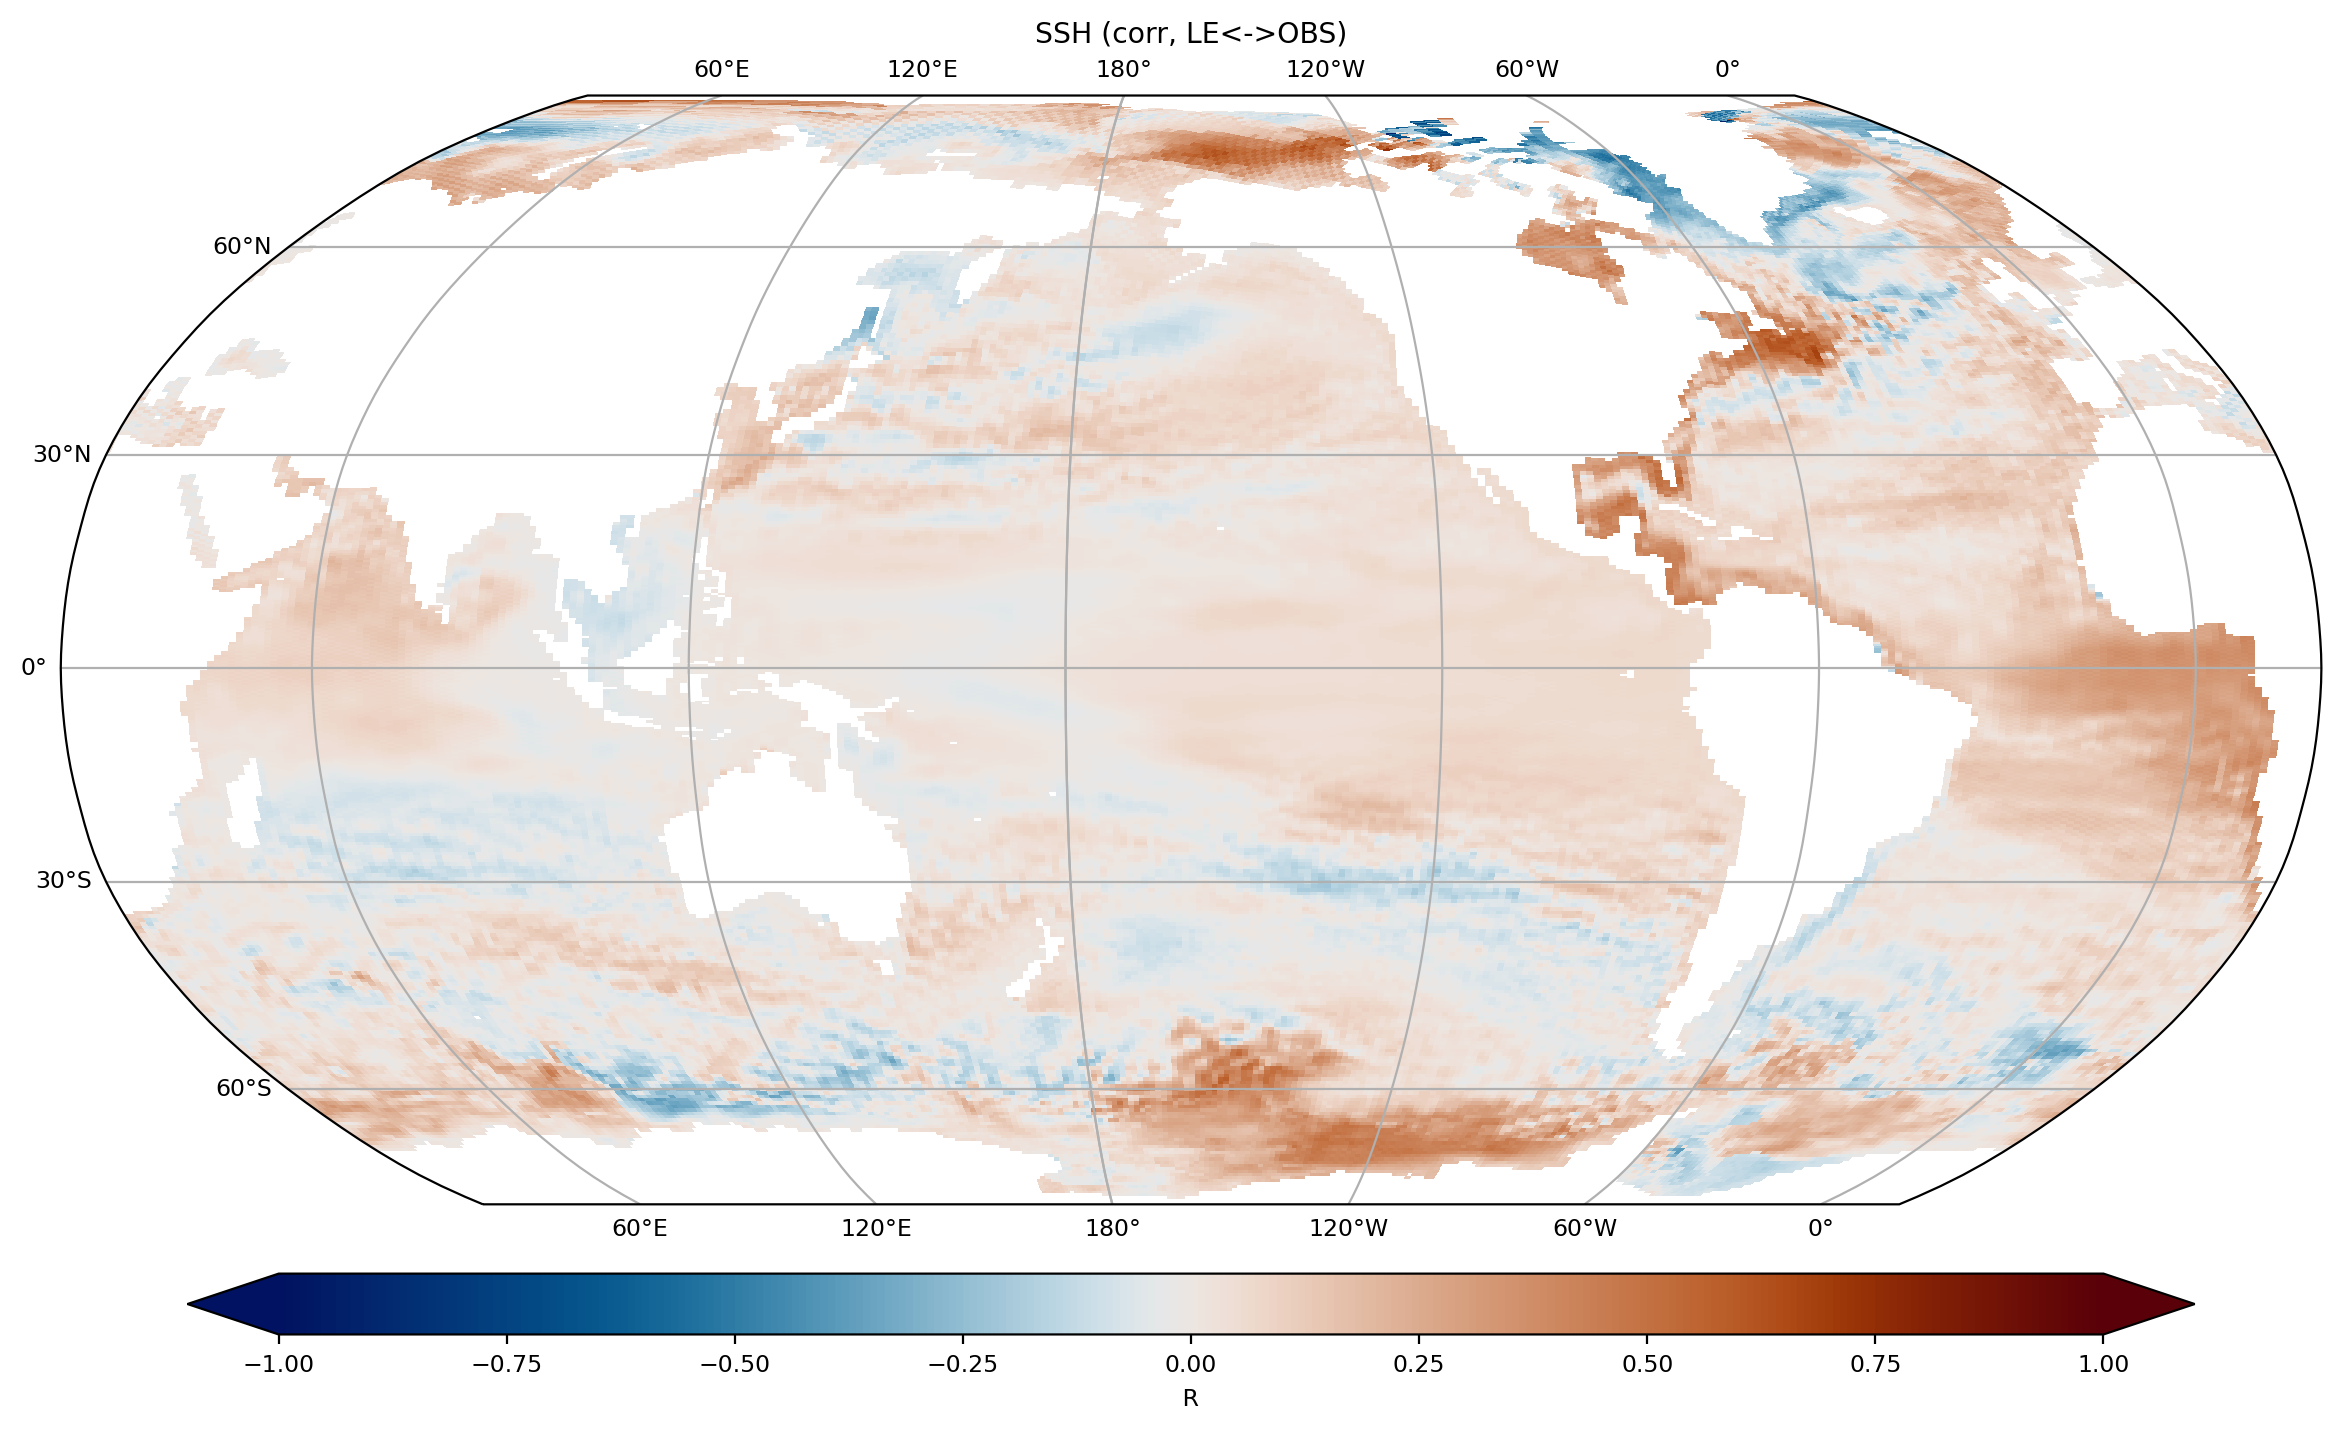

In [16]:
# plot for LE


varn=cfg_var.var #example

if cfg_var.comp=='ocn':
    ds_grid = pop_tools.get_grid('POP_gx1v7')

data_array=corr_LE.mean(dim='ens_LE')

data_array.attrs['name'] = cfg_var.var

if cfg_var.var == 'SST':
    data_array = data_array.where(data_array != 0, np.nan)
if cfg_var.comp=='ocn':
    data_array['TLONG']=ds_grid.TLONG
    data_array['TLAT']=ds_grid.TLAT

# data_array = np.nan_to_num(data_array)

# data_array.isel(concat_dim=0).isel(time=0).plot()

projection = ccrs.Robinson(central_longitude=200)

plt.rcParams.update({'font.size': 8.5})
fig, ax2 = plt.subplots(1, 1, figsize=(18.5, 9), dpi=200, facecolor='w', edgecolor='k', subplot_kw={'projection': projection})

cbar_kwargs={'orientation':'horizontal','pad':0.05,'shrink':0.7, 'label':' R ', 'aspect':33, 'extend': 'both'}
if cfg_var.comp=='ocn' or cfg_var.comp=='ice':
    # plt1=pop_add_cyclic(data_array).plot.pcolormesh(x='TLONG', y='TLAT', ax=ax2, transform=ccrs.PlateCarree(), vmax=0.05, vmin=-0.05,cmap=cm.vik, cbar_kwargs=cbar_kwargs)
    plt1=pop_add_cyclic(data_array).plot.pcolormesh(x='TLONG', y='TLAT', ax=ax2, transform=ccrs.PlateCarree(), vmax=1, vmin=-1,cmap=cm.vik, cbar_kwargs=cbar_kwargs)

else:
    plt1=data_array.isel(concat_dim=0).mean(dim='time').plot.pcolormesh(ax=ax2, transform=ccrs.PlateCarree(), vmax=30, vmin=0, cmap=cmocean.cm.deep, cbar_kwargs=cbar_kwargs)

ax2.set_title(f'{varn} (corr, LE<->OBS)')
ax2.gridlines(draw_labels=True) 

ax2.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}°'))
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0f}°'))

plt.show()

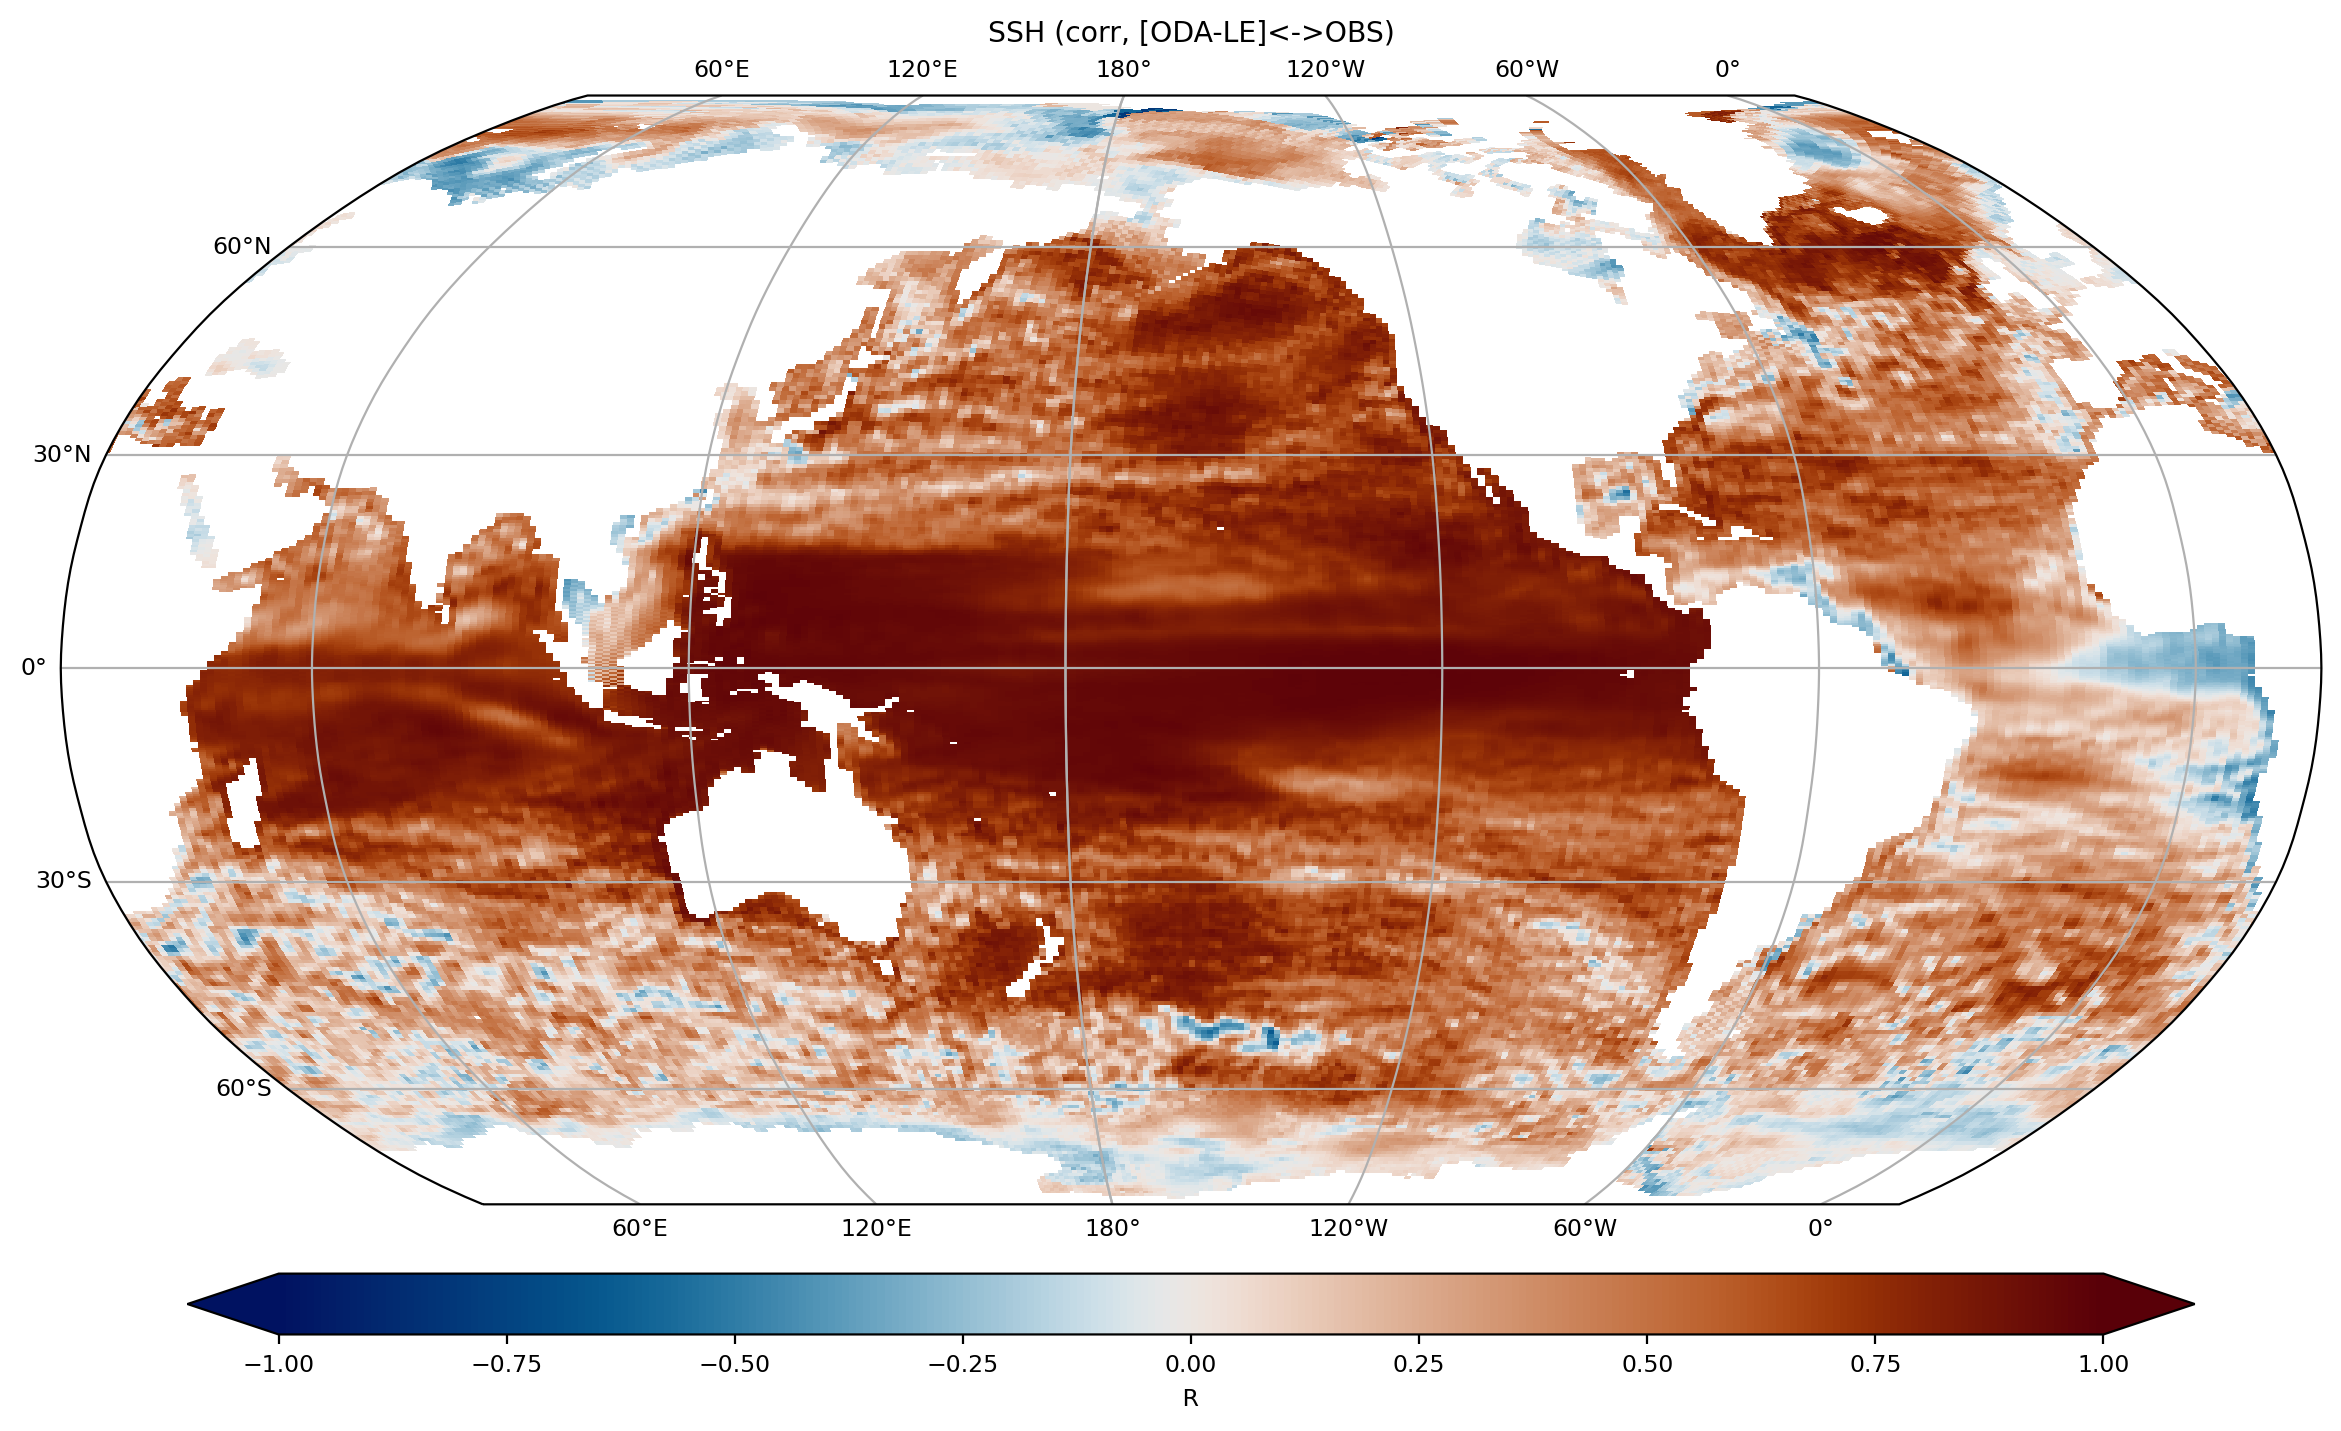

In [17]:
# plot for (ODA - LE)


varn=cfg_var.var #example

if cfg_var.comp=='ocn':
    ds_grid = pop_tools.get_grid('POP_gx1v7')

# data_array=corr.mean(dim='ens_ADA').mean(dim='concat_dim')
data_array=corr_ODA_diff.mean(dim='ens_ODA')

data_array.attrs['name'] = cfg_var.var

if cfg_var.var == 'SST':
    data_array = data_array.where(data_array != 0, np.nan)
if cfg_var.comp=='ocn':
    data_array['TLONG']=ds_grid.TLONG
    data_array['TLAT']=ds_grid.TLAT

# data_array = np.nan_to_num(data_array)

# data_array.isel(concat_dim=0).isel(time=0).plot()

projection = ccrs.Robinson(central_longitude=200)

plt.rcParams.update({'font.size': 8.5})
fig, ax2 = plt.subplots(1, 1, figsize=(18.5, 9), dpi=200, facecolor='w', edgecolor='k', subplot_kw={'projection': projection})

cbar_kwargs={'orientation':'horizontal','pad':0.05,'shrink':0.7, 'label':' R ', 'aspect':33, 'extend': 'both'}
if cfg_var.comp=='ocn' or cfg_var.comp=='ice':
    # plt1=pop_add_cyclic(data_array).plot.pcolormesh(x='TLONG', y='TLAT', ax=ax2, transform=ccrs.PlateCarree(), vmax=0.05, vmin=-0.05,cmap=cm.vik, cbar_kwargs=cbar_kwargs)
    plt1=pop_add_cyclic(data_array).plot.pcolormesh(x='TLONG', y='TLAT', ax=ax2, transform=ccrs.PlateCarree(), vmax=1, vmin=-1,cmap=cm.vik, cbar_kwargs=cbar_kwargs)

else:
    plt1=data_array.isel(concat_dim=0).mean(dim='time').plot.pcolormesh(ax=ax2, transform=ccrs.PlateCarree(), vmax=30, vmin=0, cmap=cmocean.cm.deep, cbar_kwargs=cbar_kwargs)

ax2.set_title(f'{varn} (corr, [ODA-LE]<->OBS)')
ax2.gridlines(draw_labels=True) 

ax2.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}°'))
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0f}°'))

plt.show()

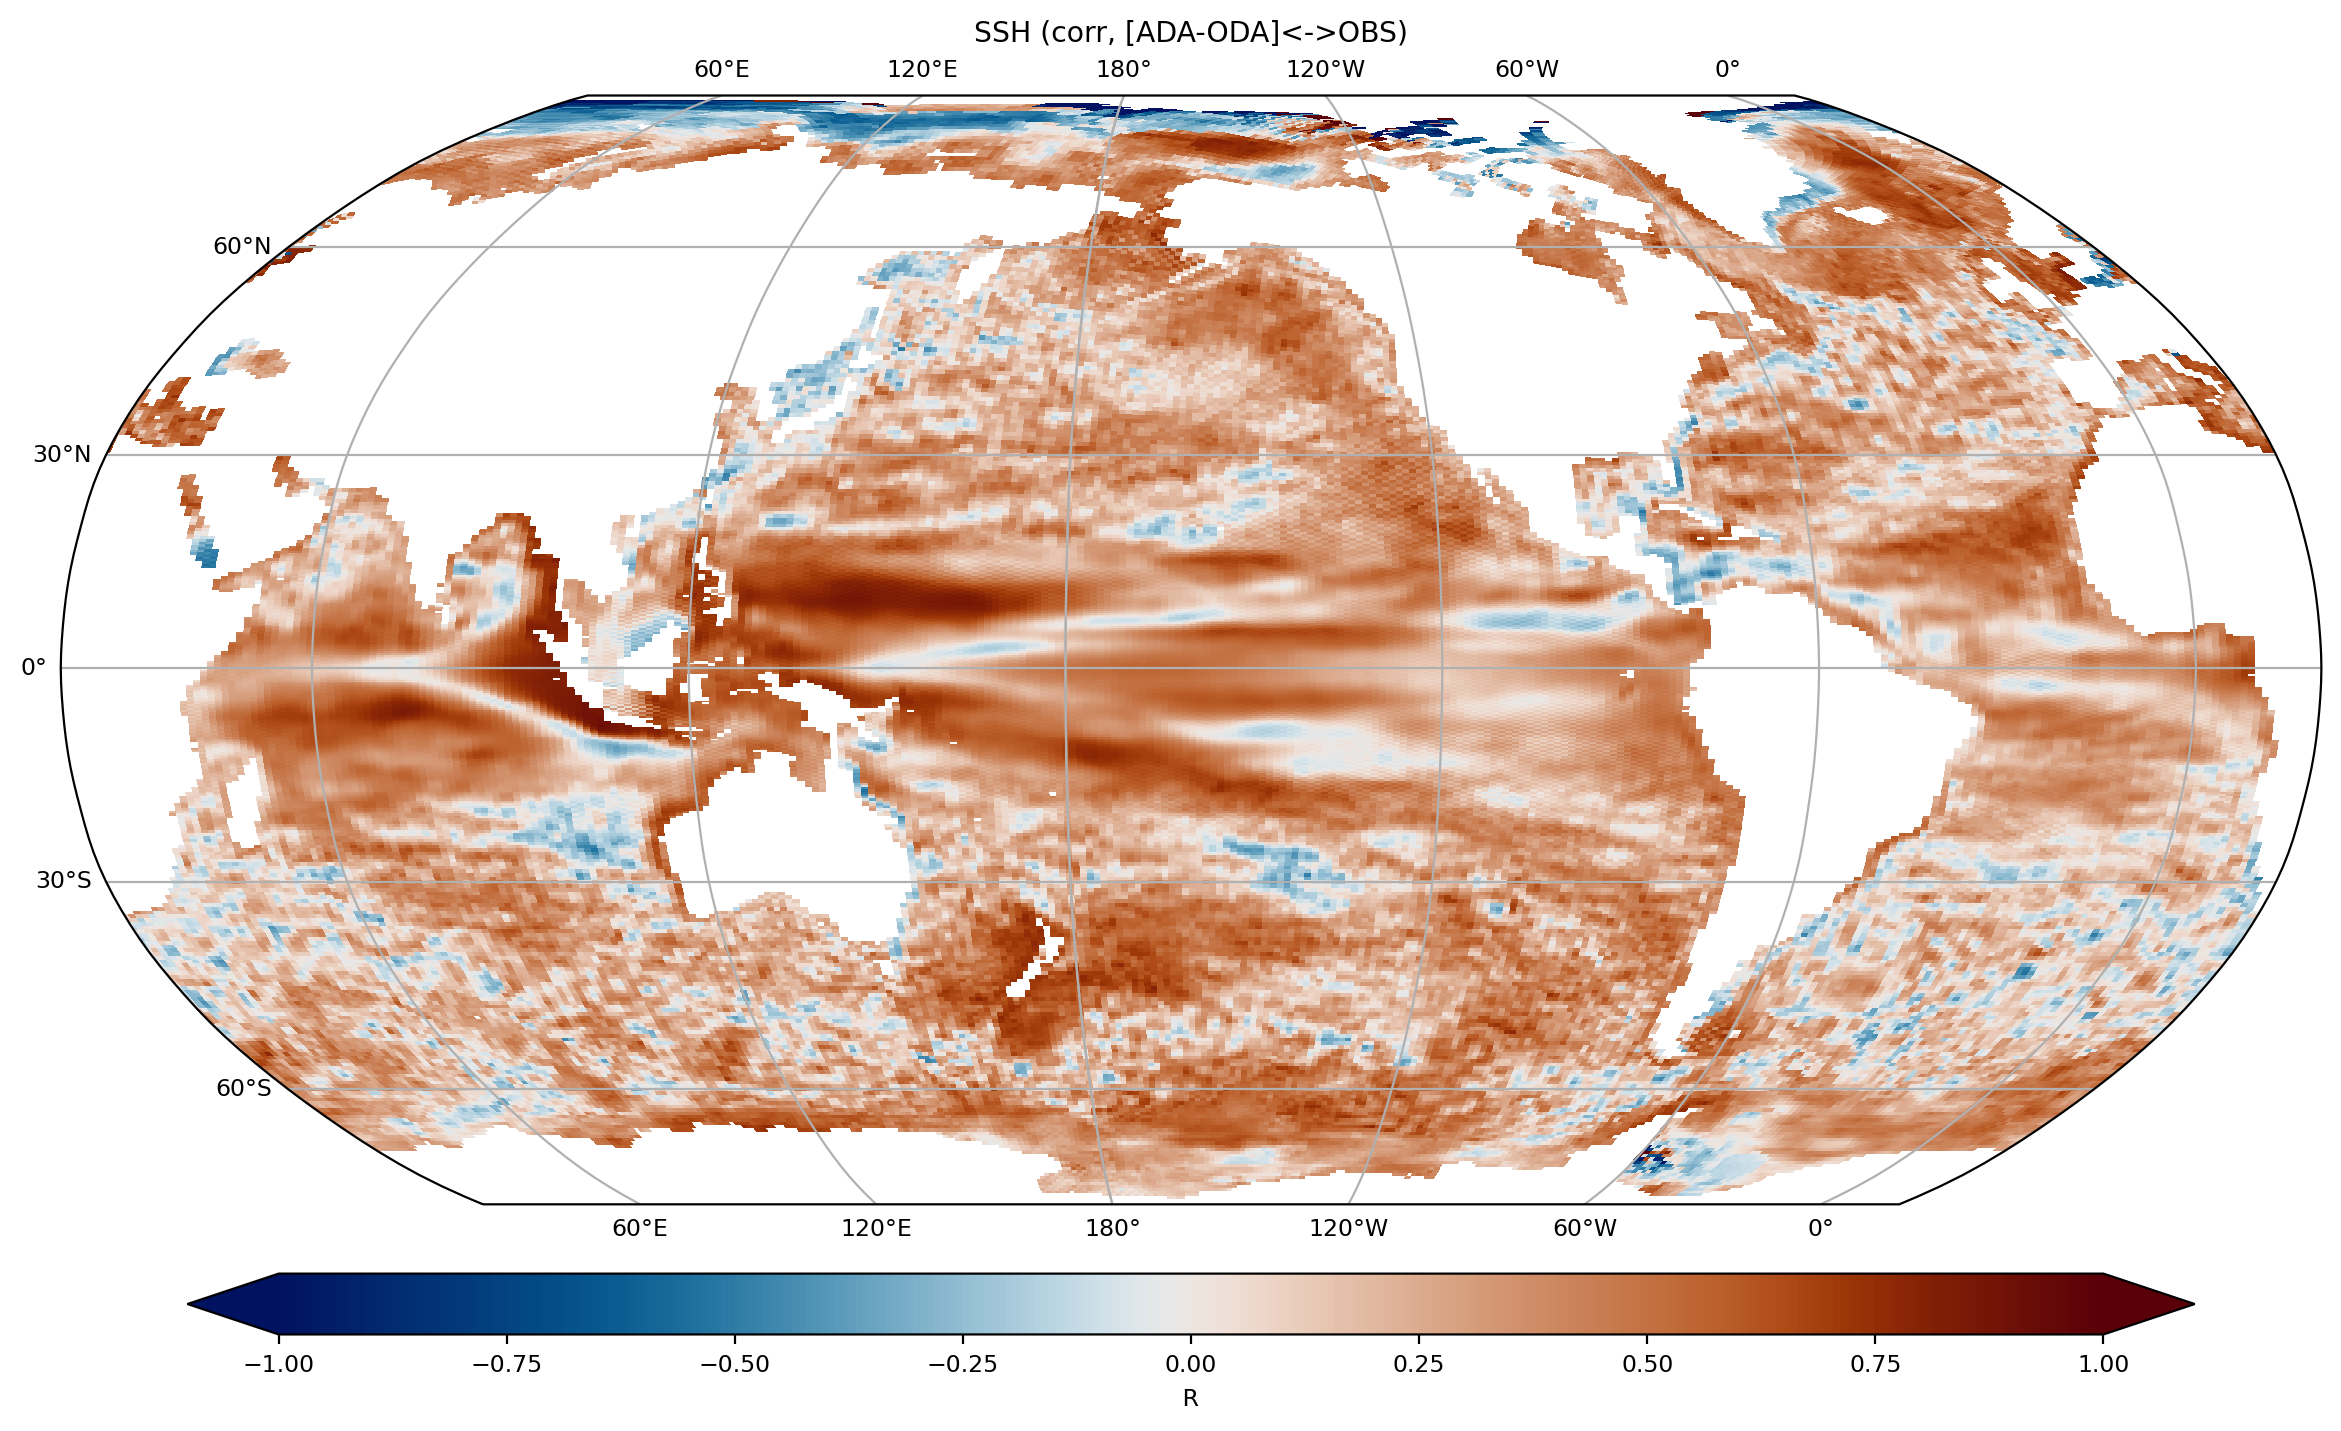

In [18]:
# plot for (ADA - ODA)


varn=cfg_var.var #example

if cfg_var.comp=='ocn':
    ds_grid = pop_tools.get_grid('POP_gx1v7')

# data_array=corr.mean(dim='ens_ADA').mean(dim='concat_dim')
data_array=corr_ADA_diff.mean(dim='ens_ADA')

data_array.attrs['name'] = cfg_var.var

if cfg_var.var == 'SST':
    data_array = data_array.where(data_array != 0, np.nan)
if cfg_var.comp=='ocn':
    data_array['TLONG']=ds_grid.TLONG
    data_array['TLAT']=ds_grid.TLAT

# data_array = np.nan_to_num(data_array)

# data_array.isel(concat_dim=0).isel(time=0).plot()

projection = ccrs.Robinson(central_longitude=200)

plt.rcParams.update({'font.size': 8.5})
fig, ax2 = plt.subplots(1, 1, figsize=(18.5, 9), dpi=200, facecolor='w', edgecolor='k', subplot_kw={'projection': projection})

cbar_kwargs={'orientation':'horizontal','pad':0.05,'shrink':0.7, 'label':' R ', 'aspect':33, 'extend': 'both'}
if cfg_var.comp=='ocn' or cfg_var.comp=='ice':
    # plt1=pop_add_cyclic(data_array).plot.pcolormesh(x='TLONG', y='TLAT', ax=ax2, transform=ccrs.PlateCarree(), vmax=0.05, vmin=-0.05,cmap=cm.vik, cbar_kwargs=cbar_kwargs)
    plt1=pop_add_cyclic(data_array).plot.pcolormesh(x='TLONG', y='TLAT', ax=ax2, transform=ccrs.PlateCarree(), vmax=1, vmin=-1,cmap=cm.vik, cbar_kwargs=cbar_kwargs)

else:
    plt1=data_array.isel(concat_dim=0).mean(dim='time').plot.pcolormesh(ax=ax2, transform=ccrs.PlateCarree(), vmax=30, vmin=0, cmap=cmocean.cm.deep, cbar_kwargs=cbar_kwargs)

ax2.set_title(f'{varn} (corr, [ADA-ODA]<->OBS)')
ax2.gridlines(draw_labels=True) 

ax2.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}°'))
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0f}°'))

plt.show()

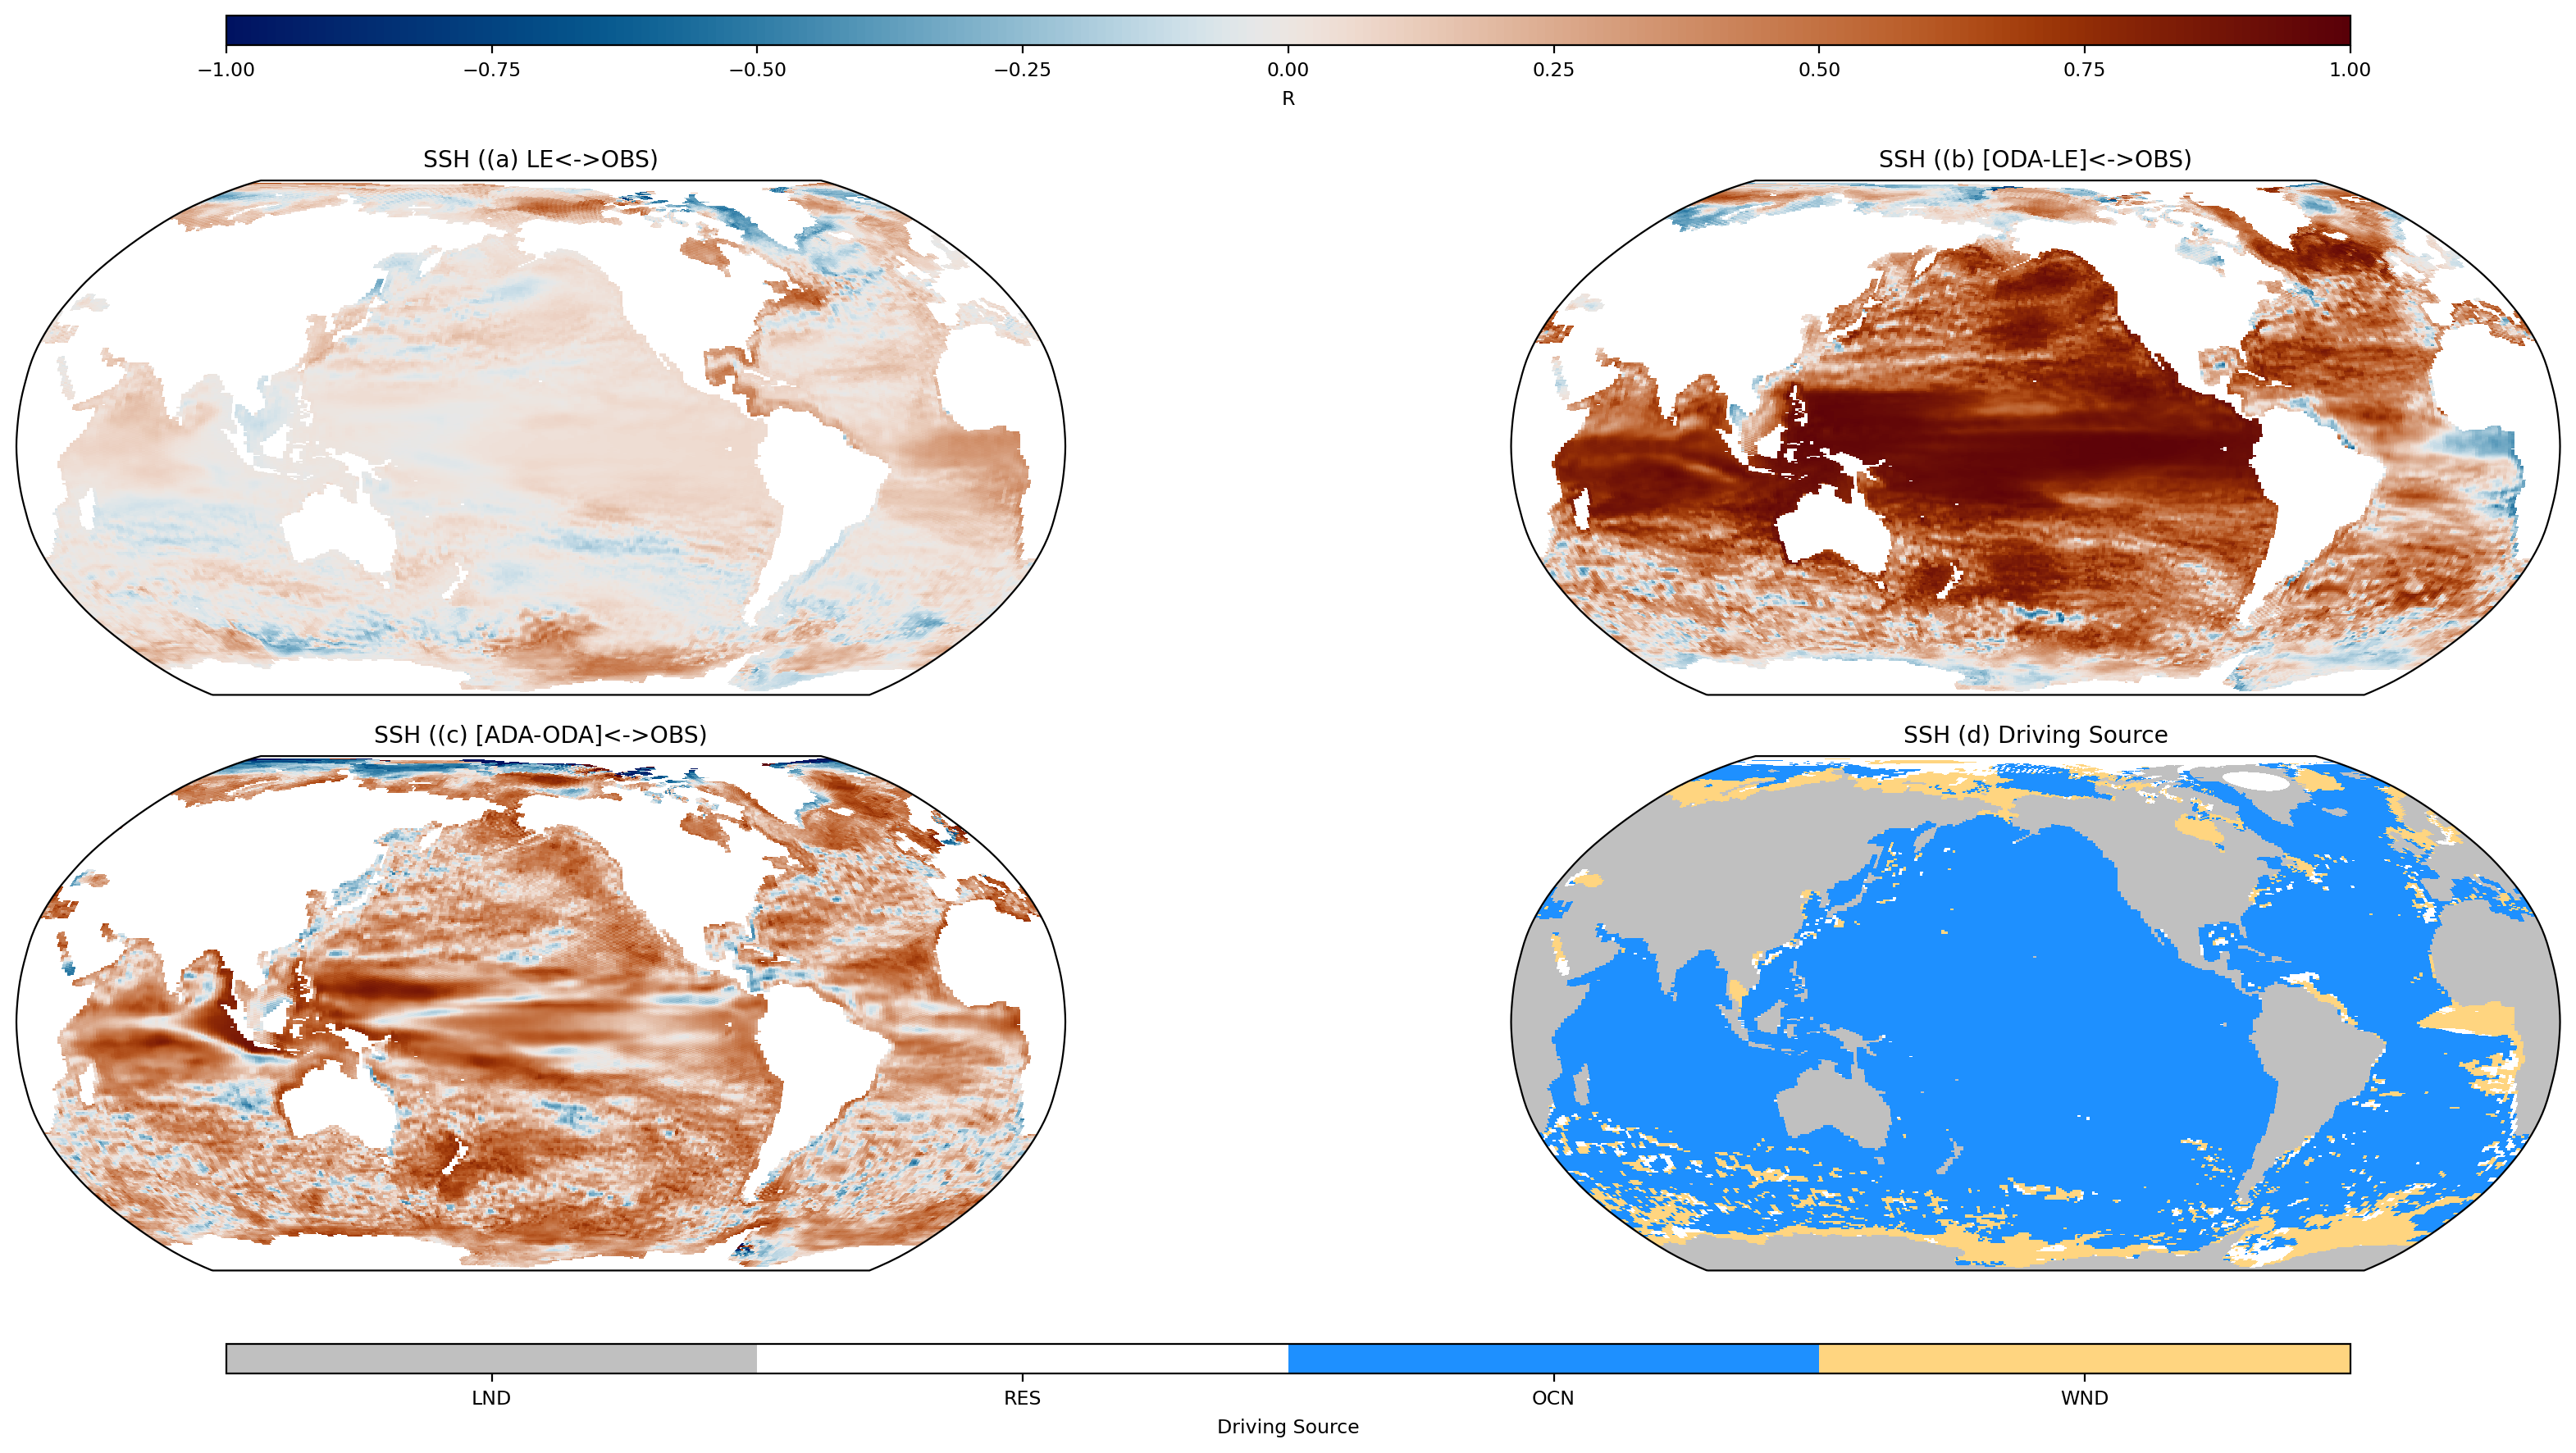

In [19]:
# plot for LE

varn=cfg_var.var #example

if cfg_var.comp=='ocn':
    ds_grid = pop_tools.get_grid('POP_gx1v7')

projection = ccrs.Robinson(central_longitude=205)
cbar_kwargs={'orientation':'horizontal','pad':0.05,'shrink':0.7, 'label':' R ', 'aspect':33, 'extend': 'both'}

# 서브플롯 생성
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18.5, 9), 
             dpi=200, facecolor='w', edgecolor='k', subplot_kw={'projection': projection}, constrained_layout=False)

data_array=corr_LE.mean(dim='ens_LE')
data_array.attrs['name'] = cfg_var.var
if cfg_var.var == 'SST':
    data_array = data_array.where(data_array != 0, np.nan)
if cfg_var.comp=='ocn':
    data_array['TLONG']=ds_grid.TLONG
    data_array['TLAT']=ds_grid.TLAT


plt1=pop_add_cyclic(data_array).plot.pcolormesh(x='TLONG', y='TLAT', 
                ax=axes[0, 0], transform=ccrs.PlateCarree(), vmax=1, vmin=-1,cmap=cm.vik, add_colorbar=False)
#                ax=axes[0, 0], transform=ccrs.PlateCarree(), vmax=1, vmin=-1,cmap=cm.vik, cbar_kwargs=cbar_kwargs)

axes[0, 0].set_title(f'{varn} ((a) LE<->OBS)')
# axes[0, 0].gridlines(draw_labels=True) 
# axes[0, 0].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}°'))
# axes[0, 0].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0f}°'))

# plot for (ODA - LE)
data_array=corr_ODA_diff.mean(dim='ens_ODA')
data_array.attrs['name'] = cfg_var.var
if cfg_var.var == 'SST':
    data_array = data_array.where(data_array != 0, np.nan)
if cfg_var.comp=='ocn':
    data_array['TLONG']=ds_grid.TLONG
    data_array['TLAT']=ds_grid.TLAT
    
plt2=pop_add_cyclic(data_array).plot.pcolormesh(x='TLONG', y='TLAT', 
                    ax=axes[0, 1], transform=ccrs.PlateCarree(), vmax=1, vmin=-1,cmap=cm.vik, add_colorbar=False)
#ax=axes[0, 1], transform=ccrs.PlateCarree(), vmax=1, vmin=-1,cmap=cm.vik, cbar_kwargs=cbar_kwargs)

axes[0, 1].set_title(f'{varn} ((b) [ODA-LE]<->OBS)')
# axes[0, 1].gridlines(draw_labels=True) 
# axes[0, 1].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}°'))
# axes[0, 1].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0f}°'))


# plot for (ADA - ODA)
data_array=corr_ADA_diff.mean(dim='ens_ADA')
data_array.attrs['name'] = cfg_var.var
if cfg_var.var == 'SST':
    data_array = data_array.where(data_array != 0, np.nan)
if cfg_var.comp=='ocn':
    data_array['TLONG']=ds_grid.TLONG
    data_array['TLAT']=ds_grid.TLAT
    
plt3=pop_add_cyclic(data_array).plot.pcolormesh(x='TLONG', y='TLAT', 
                    ax=axes[1, 0], transform=ccrs.PlateCarree(), vmax=1, vmin=-1,cmap=cm.vik, add_colorbar=False)
#ax=axes[1, 0], transform=ccrs.PlateCarree(), vmax=1, vmin=-1,cmap=cm.vik, cbar_kwargs=cbar_kwargs)

axes[1, 0].set_title(f'{varn} ((c) [ADA-ODA]<->OBS)')
# axes[1, 0].gridlines(draw_labels=True) 
# axes[1, 0].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}°'))
# axes[1, 0].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0f}°'))


# plot for (WND ODA mask)

# 유의 수준 설정
alpha = 0.10

t_stat_LE, p_values_LE = ttest_1samp(corr_LE, 0, axis=0)
ds_LE = corr_LE.mean(dim='ens_LE').where(p_values_LE < alpha)

t_stat_ODA, p_values_ODA = ttest_1samp(corr_ODA_diff, 0, axis=0)
ds_ODA = corr_ODA_diff.mean(dim='ens_ODA').where(p_values_ODA < alpha)

t_stat_ADA, p_values_ADA = ttest_1samp(corr_ADA_diff, 0, axis=0)
ds_ADA = corr_ADA_diff.mean(dim='ens_ADA').where(p_values_ADA < alpha)

ds_LE.attrs['name'] = cfg_var.var

if cfg_var.var == 'SST':
    ds_LE = ds_LE.where(ds_LE != 0, np.nan)

if cfg_var.comp == 'ocn':
    ds_LE['TLONG'] = ds_grid.TLONG
    ds_LE['TLAT'] = ds_grid.TLAT

threshold = 0
mask_LE = ds_LE > threshold
mask_ODA = ds_ODA > threshold
mask_ADA = ds_ADA > threshold

ds_all = xr.Dataset(
    data_vars=dict(
        colors=(('nlat', 'nlon'), np.full(ds_LE.shape, 0.33))  # 'colors'라는 변수 추가
    ),
    coords=dict(
        TLONG=(('nlat', 'nlon'), ds_grid.TLONG.data),  # DataArray의 .data 사용
        TLAT=(('nlat', 'nlon'), ds_grid.TLAT.data)     # DataArray의 .data 사용
    )
)

ds_all['colors'] = xr.where(ds_grid.REGION_MASK == 0, 0.0, ds_all['colors']) # 흰색
ds_all['colors'] = xr.where(mask_ODA & ~mask_ADA, 0.67, ds_all['colors'])  # 파란색
ds_all['colors'] = xr.where(mask_ODA & mask_ADA, 0.67, ds_all['colors'])  # 파란색
ds_all['colors'] = xr.where(~mask_ODA & mask_ADA, 1.0, ds_all['colors'])  # 주황색

colors_custom = [ '#C0C0C0', # 밝은 회색 (Residual)
          '#FFFFFF',  # 흰색 (White)
          '#1E90FF',  # Dodger blue (ODA)
          '#FFD580']  # 파스텔 오렌지 (WND) 

plt4=pop_add_cyclic(ds_all['colors']).plot.pcolormesh(x='TLONG', y='TLAT', 
      ax=axes[1, 1], transform=ccrs.PlateCarree(), cmap=mcolors.ListedColormap(colors_custom), add_colorbar=False)
#ax=axes[1, 1], transform=ccrs.PlateCarree(), cmap=mcolors.ListedColormap(colors_custom), cbar_kwargs=cbar_kwargs)

axes[1, 1].set_title(f'{varn} (d) Driving Source')
# axes[1, 1].gridlines(draw_labels=True) 
# axes[1, 1].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}°'))
# axes[1, 1].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0f}°'))

# (a), (b), (c) 서브플롯에 대해 위쪽에 큰 컬러바 추가
cbar_a_c = fig.add_axes([0.15, 0.95, 0.7, 0.02])  # [left, bottom, width, height] 비율로 컬러바 위치와 크기 설정
cbar1 = fig.colorbar(plt1, cax=cbar_a_c, orientation='horizontal')
cbar1.set_label('R')

# (d) 서브플롯에 대해 아래쪽에 큰 컬러바 추가
cbar_d = fig.add_axes([0.15, 0.05, 0.7, 0.02])  # [left, bottom, width, height] 비율로 컬러바 위치와 크기 설정
cbar2= fig.colorbar(plt4, cax=cbar_d, orientation='horizontal')
cbar2.set_label('Driving Source')
num_colors = len(colors_custom)
tick_locs = np.linspace(0.5 / num_colors, 1 - 0.5 / num_colors, num_colors)
cbar2.set_ticks(tick_locs)  # 눈금 설정
cbar2.set_ticklabels(['LND', 'RES', 'OCN', 'WND'])  # 눈금 레이블 설정

plt.rcParams.update({'font.size': 12})

# 전체 레이아웃 조정
plt.tight_layout(rect=[0, 0.1, 1, 0.9])  # 상단과 하단의 레이아웃 여백을 맞추기 위해 rect 설정
# plt.tight_layout()
plt.show()
